# Optimization

<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>Setup</h1></u>
</div>

In the finite-dimensional unconstrained optimization problem, one is given a function $f : R^n \mapsto R$ and asked to find an $x^∗$ such that $f (x^∗) \geq f(x)$ for all $x$. We call $f$ the objective function and $x^∗$ , if it exists, the global maximum of $f$. We focus on maximization - to solve a minimization problem, simply maximize the negative of the objective.

We say that $x^∗ \in R^n$ is a ...

* strict global maximum of $f$ if $f(x^∗) > f (x)$ for all $x\neq x^∗$.
* weak local maximum of $f$ if $f(x^∗) \geq f(x)$ for all $x$ in some neighborhood of $x^∗$.
* strict local maximum of $f$ if $f(x^∗) > f(x)$ for all $x\neq x^∗$ in some neighborhood of $x^∗$.

<img src="material/fig-local-global.png" width=500 height=500 />


Let $f: R^n \mapsto R$ be twice continously differentiable.

* **First Order Necessary Conditions:** If $x^*$ is a local maximum of $f$, then $f^{\prime}(x^*) = 0$. 
* **Second Order Necessary Condition:** If $x^∗$ is a local maximum of $f$, then $f^{\prime\prime}(x^*)$ is negative semidefinite. 

We say $x$ is a critical point of $f$ if it satisfies the first-order necessary condition.

* **Sufficient Condition:** If $f^\prime (x^∗) = 0$ and $f^{\prime\prime}(x^∗)$ is negative definite, then $x^∗$ is a strict local maximum of $f$.
* **Local-Global Theorem:** If $f$ is concave, and $x^∗$ is a local maximum of $f$, then $x^∗$ is a global maximum of $f$.

**Key problem attributes**

* Convexity: convex vs. non-convex
* Optimization-variable type: continuous vs. discrete
* Constraints: unconstraint vs. constraint
* Number of optimization variables: low-dimensional vs. high-dimensional

These attributes dictate:

* ability to find solution
* problem complexity and computing time
* appropriate methods
* relevant software

$\Rightarrow$ Always begin by categorizing your problem



Optimization problems are ubiquitous in economics:

* Government maximizes social welfare
* Competitive equilibrium maximizes total surplus
* Ordinary least squares estimator minimizes sum of squares
* Maximum likelihood estimator maximizes likelihood function

In [1]:
from functools import partial

from scipy import optimize as opt
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import scipy as sp
import pandas as pd
import numpy as np

from optimization_problems import get_test_function_gradient
from optimization_problems import get_test_function_fast
from optimization_problems import get_parameterization
from optimization_problems import get_test_function
from optimization_auxiliary import process_results
from optimization_auxiliary import get_bounds
from optimization_plots import plot_contour
from optimization_plots import plot_surf

<div class="alert alert-block alert-info">
    <u><h2>Algorithms</h2></u>
</div>

We are mostly blind to the function we are trying to minimize and can only compute the function at a limited number of points. Each evaluation is computationally expensive.

<img src="material/fig-limited-points.png" width=500 height=500 />

**Goals**

* reasonable memory requirements
* low failure rate, convergence conditions are met
* convergence in a few iterations with low cost for each iteration

**Catergorization**

* gradient-based vs. derivative-free
* global vs. local


<div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>How to compute derivatives?</li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    <u><h2>Gradient-based methods</h2></u>
</div>

**Benefits**

* efficient for many variables
* well-suited for smooth objective and constraint functions

**Drawbacks**

* requires computing the gradient, potentially challenging and time-consuming
* convergence is only local
* not-well suited for noisy functions, derivative information flawed

Second derivative are also very useful, but ...

* Hessians are $n\times n$, so expensive to construct and store
* often only approximated using quasi-Newton methods

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>How to use gradient-based algorithms to find a global optimum?</li>
  <li>Any ideas on how to reduce the memory requirements for a large Hessian?</li>
    </ul> 
</div>

<img src="material/fig-gradient-based-algorithm.png" width=500 height=500 />


<img src="material/fig-gradient-based-overview.png" width=500 height=500 />


There is two different classes of gradient-based algorithms.

* Line-search methods
    * compute $p_k$ be a descent direction
    * compute $a_k$ to produce a sufficient decrease in the objective function

Let's see [here](https://github.com/scipy/scipy/blob/8e30f7797bd1ee442f4f1a25172e4402521c1e16/scipy/optimize/optimize.py#L1484) for how such a line search looks like in practice for the [Newton-CG](https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method) algorithm.

* Trust-region methods
    * determine a maximum allowable step length (trust-region radius) $\delta k$
    * compute step $k$ with $||p_k|| \leq \Delta$ using a model $m(p) \approx f(x_k + p)$

As an example implementation, see [here](https://github.com/scipy/scipy/blob/46b359bfb54072dae61882731bb2e766e38ba393/scipy/optimize/_trustregion.py#L100) for the `scipy.optimize_trustregion.py` implementation.

<div class="alert alert-block alert-info">
    <u><h2>Derivative-Free Methods</h2></u>
</div>

**Benefits**

* often better at finding a global minimum if function not convex
* robust with respect to noise in criterion function
* amenable to parallelization


**Drawbacks**

* extremely slow convergence for high-dimensional problems

There are two different classes of derivative-free algorithms.

* heuristic, inspired by nature
    * basin-hopping
    * evolutionary algorithms

* direct search
    * directional
    * simplicial

<div class="alert alert-block alert-info">
    <u><h2>Test function</h2></u>
</div>

$$
f(x) = \tfrac{1}{2}\sum_{i=1}^n a_i\cdot (x_i-1)^2+ b\cdot \left[ n-\sum_{i=1}^n\cos(2\pi(x_i-1))\right],
$$

where $a_i$ and $b$ provide the parameterization of the function.

<div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li>Implement this test function.</li>
         <li>Visualize the shape of our test function for the one-dimensional case.</li>
      <li>What is the role of the parameters $a_1$ and $b$? </li>
      <li>What is the functions global minimum? </li>
    </ul> 
</div>

In [2]:
??get_test_function

Signature: get_test_function(x, a, b)
Docstring: <no docstring>
Source:   
def get_test_function(x, a, b):
    x, a = np.atleast_1d(x), np.atleast_1d(a)
    dimension = len(x)

    fval = 0
    for n in range(dimension):
        fval += a[n] * (x[n] - 1) ** 2

    fval = 0.5 * fval
    fval += b * dimension

    for n in range(dimension):
        fval -= b * np.cos(2 * np.pi * (x[n] - 1))

    return fval
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_problems.py
Type:      function


In [3]:
??get_parameterization

Signature: get_parameterization(dimension, add_noise, add_illco)
Docstring: <no docstring>
Source:   
def get_parameterization(dimension, add_noise, add_illco):
    if add_noise:
        b = 1
    else:
        b = 0

    if add_illco:
        a = np.exp(np.random.uniform(high=20, size=dimension))
        a = a / np.max(a)
    else:
        a = np.ones(dimension)

    return a, b
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_problems.py
Type:      function


We want to be able to use our test function for different configurations of the challenges introduced by noise and ill-conditioning.

In [4]:
add_noise, add_illco, x0 = True, True, [4.5, -1.5]


def get_problem(dimension, add_noise, add_illco, seed=123):
    np.random.seed(seed)
    a, b = get_parameterization(dimension, add_noise, add_illco)
    get_test_function_p = partial(get_test_function, a=a, b=b)
    get_test_function_gradient_p = partial(get_test_function_gradient, a=a, b=b)
    return get_test_function_p, get_test_function_gradient_p


dimension = len(x0)
opt_test_function, opt_test_gradient = get_problem(dimension, add_noise, add_illco)
np.testing.assert_equal(opt_test_function([1, 1]), 0.0)

Let's see how the surface and contour plots look like under different scenarios.

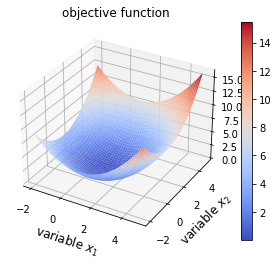

In [5]:
opt_test_function, _ = get_problem(dimension, add_noise=False, add_illco=False)
plot_surf(opt_test_function, dimension=2)

<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

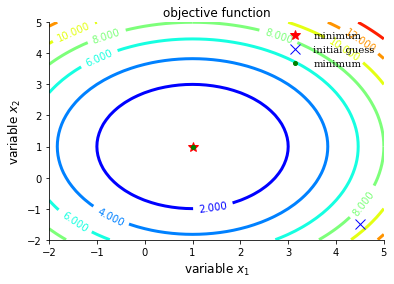

In [6]:
opt_test_function, _ = get_problem(dimension, add_noise=False, add_illco=False)
plot_contour(opt_test_function, [1, 1], "minimum")

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>How is the global maximum affected by the additon of noise and ill-conditioning?</li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    <u><h2>Benchmarking exercise</h2></u>
</div>


Let's get our problem setting and initialize a container for our results. We will use the convenient interface to [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Its documentation also points you to research papers and textbooks where the details of the algorithms are discussed in more detail. We need to invest a little in the design of our setup first, but then we can run the benchmarking exercise with ease and even adding additional optimization algorithms is straightforward.

In [44]:
ALGORITHMS = ["CG", "Newton-CG", "Nelder-Mead", "Diff-Evol"]
add_noise, add_illco, dimension = False, False, 2

In [45]:
x0 = np.zeros(dimension)
opt_test_function, opt_test_gradient = get_problem(dimension, add_noise, add_illco)
df = pd.DataFrame(columns=["Iteration", "Distance"], index=ALGORITHMS)
df.index.name = "Method"

Let's fix what will stay unchanged throughout.

In [34]:
call_optimizer = partial(
    opt.minimize,
    fun=opt_test_function,
    x0=x0,
    jac=opt_test_gradient,
    options={"disp": True, "return_all": True, "maxiter": 100000},
)

We prepared some functions to process results from the optimizer calls.

In [35]:
??process_results

Signature: process_results(df, method, res)
Docstring: <no docstring>
Source:   
def process_results(df, method, res):
    minimum = np.ones(res["x"].shape[0])
    dist = np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum)
    df.loc[method, :] = [res.nfev, dist]
    return df
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_auxiliary.py
Type:      function


## Conjugate gradient


Optimization terminated successfully.
         Current function value: 0.975247
         Iterations: 2
         Function evaluations: 9
         Gradient evaluations: 7


<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

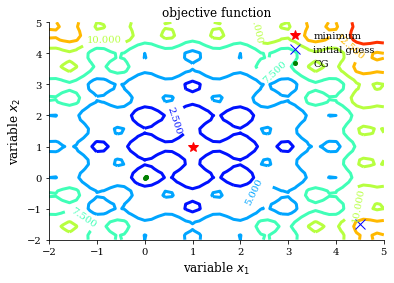

In [36]:
method = "CG"
res = call_optimizer(method=method)
df = process_results(df, method, res)
plot_contour(opt_test_function, res.allvecs, method)

##  Newton-CG

Optimization terminated successfully.
         Current function value: 0.975247
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 7
         Hessian evaluations: 0


<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

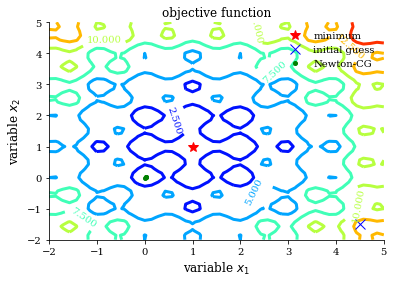

In [37]:
method = "Newton-CG"
res = call_optimizer(method=method)
df = process_results(df, method, res)
plot_contour(opt_test_function, res.allvecs, method)

## Nelder Mead

Optimization terminated successfully.
         Current function value: 0.975247
         Iterations: 28
         Function evaluations: 51


/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)


<module 'matplotlib.pyplot' from '/home/peisenha/local/anaconda3/envs/ose-course-scientific-computing/lib/python3.7/site-packages/matplotlib/pyplot.py'>

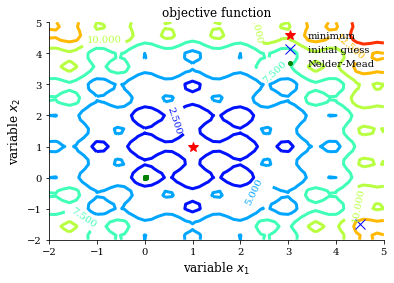

In [38]:
method = "Nelder-Mead"
res = call_optimizer(method=method)
df = process_results(df, method, res)
plot_contour(opt_test_function, res.allvecs, method)

## Differential evolution

In [39]:
??get_bounds

Signature: get_bounds(dimension)
Docstring: <no docstring>
Source:   
def get_bounds(dimension):
    bounds = np.tile(np.nan, [dimension, 2])
    bounds[:, 0], bounds[:, 1] = -10, 10
    return bounds
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_auxiliary.py
Type:      function


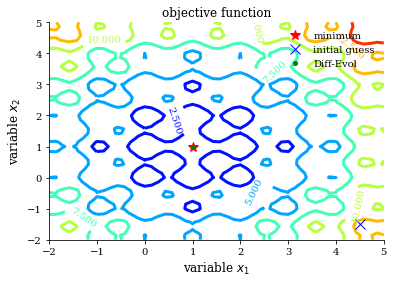

In [40]:
method = "Diff-Evol"
res = opt.differential_evolution(opt_test_function, get_bounds(dimension))
plot_contour(opt_test_function, res["x"], method)
df = process_results(df, method, res)

## Summary

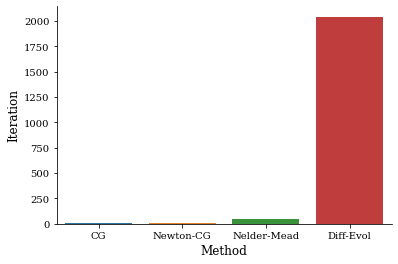

In [41]:
_ = sns.barplot(x="Method", y="Iteration", data=df.reset_index())

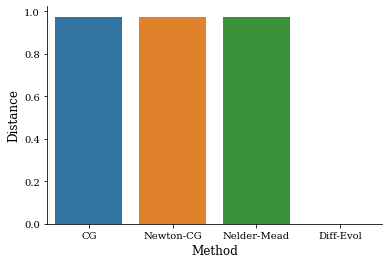

In [42]:
_ = sns.barplot(x="Method", y="Distance", data=df.reset_index())

## Speeding up test function

We want to increase the dimensionality of our optimization problem going forward. Even in this easy setting, it is worth to re-write our objective function using `numpy` to ensure its speedy execution.

In [43]:
??get_test_function

Signature: get_test_function(x, a, b)
Docstring: <no docstring>
Source:   
def get_test_function(x, a, b):
    x, a = np.atleast_1d(x), np.atleast_1d(a)
    dimension = len(x)

    fval = 0
    for n in range(dimension):
        fval += a[n] * (x[n] - 1) ** 2

    fval = 0.5 * fval
    fval += b * dimension

    for n in range(dimension):
        fval -= b * np.cos(2 * np.pi * (x[n] - 1))

    return fval
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_problems.py
Type:      function


In [19]:
??get_test_function_fast

Signature: get_test_function_fast(x, a, b)
Docstring: <no docstring>
Source:   
def get_test_function_fast(x, a, b):
    x, a = np.atleast_1d(x), np.atleast_1d(a)
    dimension = len(x)

    fval = 0
    fval += 0.5 * np.sum(a * (x - np.ones(dimension)) ** 2)
    fval += b * dimension
    fval -= b * np.sum(np.cos(2 * np.pi * (x - np.ones(dimension))))

    return fval
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_problems.py
Type:      function


It is very easy to introduce errors when speeding up your code as usually you face a trade-off between readability and performance. However, setting up a simple testing harness that simply compares the results between the slow, but readable, implementation and the fast one for numerous random test problems. For more automated, but random, testing see [Hypothesis](https://hypothesis.readthedocs.io/en/latest/).

In [20]:
def get_speed_test_problem():
    add_illco, add_noise = np.random.choice([True, False], size=2)
    dimension = np.random.randint(2, 100)

    a, b = get_parameterization(dimension, add_noise, add_illco)
    x0 = np.random.uniform(size=dimension)
    return x0, a, b

Now we are ready to put our fears at ease.

In [21]:
for _ in range(1000):
    args = get_speed_test_problem()
    stats = get_test_function(*args), get_test_function_fast(*args)
    np.testing.assert_almost_equal(*stats)

Let's see whether this was worth the effort for a small and a large problem using the `%timeit` magic function.

In [22]:
dimension, add_noise, add_illco = 100, True, True
x0 = np.random.uniform(size=dimension)
a, b = get_parameterization(dimension, add_noise, add_illco)

In [23]:
%timeit get_test_function_fast(x0, a, b)

21.5 µs ± 218 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
%timeit get_test_function(x0, a, b)

279 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In this particular setting, there is no need to increase the performance even further. However, as a next step, check out [numba](https://numba.pydata.org/), for even more flexibility in speeding up your code.

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li>Repeat the exercise in the case of noise in the criterion function and try to summarize your findings. </li>
      <li>What additional problems arise as the dimensionality of the problem for a 100-dimensional problem. Make sure to use the fast implementation of the test function. </li>
    </ul> 
</div>

</div><div class="alert alert-block alert-info">
    <u><h2>Special cases</h2></u>
</div>

Nonlinear least squares and maximum likelihood estimation have special structure that can be exploited to improve the approximation of the inverse Hessian.


### Nonlinear least squares

We will estimate the following nonlinear consumption function using data from Greene's textbook:

\begin{align*}
C = \alpha  + \beta \times Y^\gamma + \epsilon 
\end{align*}

which is estimated with quarterly data on real consumption and disposable income for the U.S. economy from 1950 to 2000.

In [25]:
df = pd.read_pickle("material/data-consumption-function.pkl")
df.head()

realgdp  realcons
Year qtr                   
1950 1     1610.5    1058.9
     2     1658.8    1075.9
     3     1723.0    1131.0
     4     1753.9    1097.6
1951 1     1773.5    1122.8

Let's confirm the basic relationship to get an idea of what to expect for the estimated parameters.

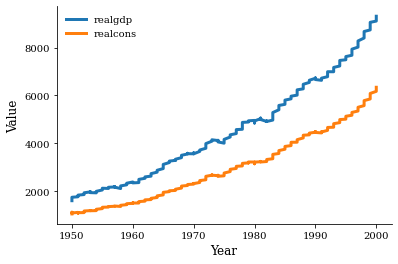

In [26]:
fig, ax = plt.subplots()
x = df.index.get_level_values("Year")

for name in ["realgdp", "realcons"]:
    y = df[name]
    ax.plot(x, y, label=name)

ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.legend()

Now we set up the criterion function such that it fits the requirements.

In [27]:
consumption = df["realcons"].values
income = df["realgdp"].values


def ssr(x, consumption, income):
    alpha, beta, gamma = x
    residuals = consumption - alpha - beta * income ** gamma
    return residuals


ssr_partial = partial(ssr, consumption=consumption, income=income)
rslt = sp.optimize.least_squares(ssr_partial, [0, 0, 1])["x"]

<div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li> Evaluate the fit the model.</li>
</ul> 

### Maximum likelihood estimation

Greene (2012) considers the following binary choice model.

\begin{align*}
P[Grade = 1] = F(\beta_0 + \beta_1 GPA + \beta_2 TUCE + \beta_3 PSI)
\end{align*}

where $F$ the cumulative distribution function for either the normal distribution (Probit) or the logistic distribution (Logit). 

In [28]:
df = pd.read_pickle("material/data-graduation-prediction.pkl")
df.head()

,GPA,TUCE,PSI,GRADE,INTERCEPT,GRADE
OBS,,,,,,
1,2.66,20,0,0,1,0
2,2.89,22,0,0,1,0
3,3.28,24,0,0,1,0
4,2.92,12,0,0,1,0
5,4.00,21,0,1,1,1


In [29]:
def probit_model(beta, y, x):
    F = norm.cdf(x @ beta)
    fval = (y * np.log(F) + (1 - y) * np.log(1 - F)).sum()
    return -fval

In [30]:
x, y = df[["INTERCEPT", "GPA", "TUCE", "PSI"]], df["GRADE"]
rslt = opt.minimize(probit_model, [0.0] * 4, args=(y, x))

 <div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li> Amend the code so that you can simply switch between estimating a Probit or Logit model.</li>
    </ul> 

### Resources

* https://kevintcarlberg.net/

### Software 

*  https://coin-or.github.io/Ipopt/

* https://ccom.ucsd.edu/~optimizers/solvers/snopt/

* https://www.gurobi.com/

* https://www.ibm.com/analytics/cplex-optimizer

### Books

* https://www.amazon.de/-/en/Jorge-Nocedal/dp/0387303030/ref=sr_1_1?dchild=1&keywords=nocedal+wright&qid=1605168584&sr=8-1* 

* https://www.amazon.de/-/en/Stephen-Boyd/dp/0521833787/ref=sr_1_3?dchild=1&keywords=optimization&qid=1605168744&sr=8-3

* https://www.amazon.de/-/en/Mykel-J-Kochenderfer/dp/0262039427/ref=sr_1_1?dchild=1&keywords=optimization&qid=1605168758&sr=8-1

* https://www.amazon.com/gp/product/0471494631/ref=ox_sc_act_title_1?ie=UTF8&smid=ATVPDKIKX0DER#reader_0471494631